<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Outlier Detection with Pyleoclim

## Authors

Deborah Khider

Author1 = {"name": "Deborah Khider", "affiliation": "Information Sciences Institute, University of Southern California", "email": "khider@usc.edu", "orcid": "0000-0001-7501-8430"}

## Preamble

### Goals

- Understand outlier detection through clustering
- Apply detection algorithm and understand the difference between the two algorithms used in Pyleoclim, namely k-means and DBSCAN. 
- Understand the diagnostic metrics returned by each algorithm
- Understand the parameters and when to apply them

**Reading time:**

### Keywords

Outlier detection; anomaly detection; clustering; unsupervised machine learning. 

### Pre-requisites

An understanding of clustering is useful

### Relevant Packages

<font color=green> sklearn? </font>

## Data Description

This tutorial makes use of the following dataset, stored in LiPD format: 

* Khider, D., Jackson, C. S., and Stott, L. D. (2014), Assessing millennial-scale variability during the Holocene: A perspective from the western tropical Pacific, Paleoceanography, 29, 143– 159, [doi:10.1002/2013PA002534](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013PA002534).


## Demonstration

Let's import the necessary packages:


In [81]:
import pyleoclim as pyleo

from pylipd.lipd import LiPD

import warnings
warnings.filterwarnings('ignore')

In [82]:
D = LiPD()

D.load('../data/MD982181.Khider.2014.lpd')

timeseries,df = D.get_timeseries(D.get_all_dataset_names(),to_dataframe=True)

df

Loading 1 LiPD files


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Loaded..
Extracting timeseries from dataset: MD982181.Khider.2014 ...


,mode,time_id,funding1_principalInvestigator,funding1_agency,funding1_country,funding1_grant,funding2_principalInvestigator,funding2_agency,funding2_grant,funding2_country,...,paleoData_interpretation,age,ageUnits,paleoData_notes,paleoData_hasResolution_hasMeanValue,paleoData_hasResolution_hasMedianValue,paleoData_hasResolution_hasMaxValue,paleoData_hasResolution_hasMinValue,paleoData_inferredVariableType,paleoData_calibration
0,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,"[{'variableDetail': 'sea surface', 'variable':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,"[{'rank': 1.0, 'variable': 'temperature', 'var...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,"[{'scope': 'Climate', 'interpDirection': 'nega...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,"[{'local': 'far-field', 'variable': 'd18Osw', ...","[1212.0, 1225.0, 1233.0, 1241.0, 1249.0, 1257....",yr BP,Average duplicates from paleo1measurementTable1,26.682065,33.0,293.0,3.0,NaN,NaN
8,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,NaN,"[1212.0, 1225.0, 1233.0, 1241.0, 1249.0, 1257....",yr BP,NaN,26.682065,33.0,293.0,3.0,NaN,NaN
9,paleoData,age,L. Stott,National Science Foundation,United States,[AGS#1049238],L. Stott,National Science Foundation,[AGS#1344514],United States,...,"[{'variable': 'age', 'variableDetail': 'calend...","[1212.0, 1225.0, 1233.0, 1241.0, 1249.0, 1257....",yr BP,NaN,26.682065,21.0,293.0,3.0,Age,NaN


Let's use the sea surface temperatures (SST) record:

In [83]:
row = df[df['paleoData_variableName']=='sst']

ts = pyleo.Series(
    time=row['age'].values[0],
    value=row['paleoData_values'].values[0],
    time_name = 'Age',
    time_unit = 'yr BP',
    value_name = 'SST',
    value_unit = 'deg C',
    label='MD982181.Khider.2014'
)

NaNs have been detected and dropped.
Time axis values sorted in ascending order


Let's plot the timeseries:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='SST [deg C]'>)

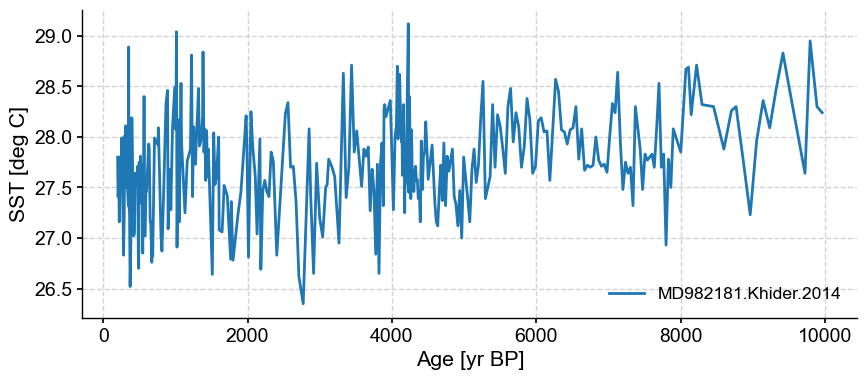

In [84]:
ts.plot()

This record contains a long-term trend through the Holocence. In addition, it is fairly noisy, with some spurious spikes. Tempted to remove them by hand? Let's use the outlier detection algorithm on this dataset first.

### Unsupervised machine learning - clustering

[Unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) learns patterns from unlabeled data. One example of unsupervised learning is [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), which groups a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). Outliers can then be identified depending on how far they fall from the cluster. They are several methods for clustering. In Pyleoclim, we make use of two algorithms:
- [k-means](https://en.wikipedia.org/wiki/K-means_clustering), which is centroid based. The principle is simple: find the $k$ cluster centers and assign the objects to the nearest cluster center, such that the squared distances from the cluster are minimized. This algorithm requires the number of clusters to be known in advance. Alternatively, one can sweep over a number of clusters and use an optimization metric to decide on the number of clusters present in the dataset. Outliers are then indentified as data falling from a certain distance away from the centroid or its local density compared to the local densities of its neighbors (LOF). We'll elaborate more on outlier detection later.
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) is an example of density-based clustering, in which clusters are defined as areas of higher density than the remainder of the data set. Data that sit in sparse areas are usually considered to be outliers. 

Let's have a look on how these two methods work for clustering. 

#### DBSCAN

Pyleoclim makes use of the method in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Let's import the package and run through an example:

In [85]:
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
import numpy as np

First, let's make some random blobs of 300 data points for illustrative purposes. Let's create four clusters, with data clustered within a 0.60 standard deviation. 

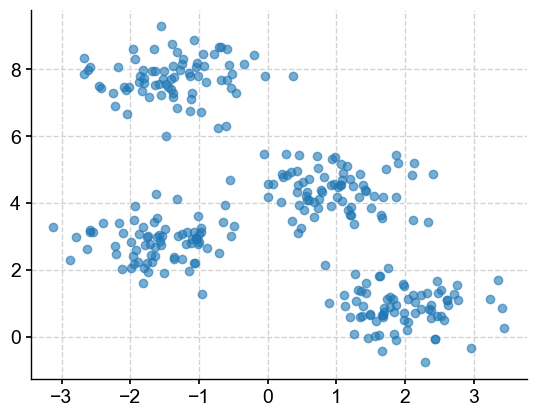

In [86]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1], alpha=0.6)

Have a look at the parameters for the [DBSCAN algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). The most relevant ones are:
* `eps`: Threshold $\epsilon$. Two points are considered neighbors if the distance between the two points is below the threshold $\epsilon$.
* `min_samples`: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s important to note that the point itself is included in the minimum number of samples. If the value of this parameter is set to 8, then there must be at least 8 points to form a cluster.
* `metric`: The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance).

Let's have a look using semi-random values for `eps` and `min_samples`:

In [87]:
m = DBSCAN(eps=0.3, min_samples=5)
m.fit(X)

DBSCAN(eps=0.3)

The `labels_` property contains the list of clusters and their respective points:

In [88]:
clusters = m.labels_
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

Using these particular values, DBSCAN identified 11 clusters (the points contained in the '-1' label are considered outliers by the algorithm), which is more than the 4 blobs they were originally created. Let's plot them in various colors. The outliers will be plotted in navy (dark blue):

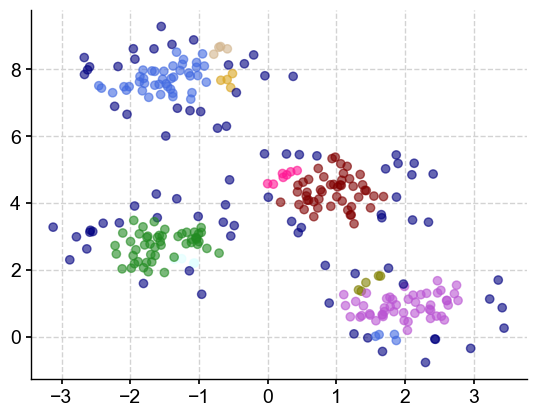

In [89]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X[:,0], X[:,1], c=vectorizer(clusters), alpha=0.6)

There seems to be a lot of outliers and clusters that seem to be very close to each other. Remember that we chose a distance threshold of 0.3. Let's increase this value to 0.7:

In [90]:
m2 = DBSCAN(eps=0.7, min_samples=5)
m2.fit(X)

DBSCAN(eps=0.7)

In [91]:
clusters = m2.labels_
np.unique(clusters)

array([-1,  0,  1,  2], dtype=int64)

We have identified 3 clusters (and other outliers).

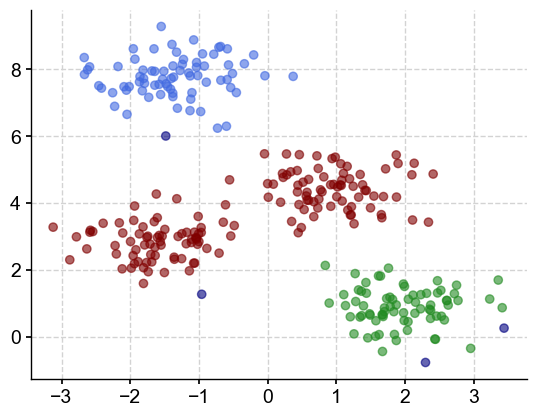

In [92]:
colors = ['royalblue', 'maroon', 'forestgreen', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X[:,0], X[:,1], c=vectorizer(clusters), alpha=0.6)

With this value of `eps`, we now have three clusters and some outliers. You may ask yourself, if this algortihm is so sensitive to the parameter values, how do I know which one to choose? One solution (the one implemented by Pyleoclim) is to sweep throught a range of values for `eps` and `min_sample` and evaluate the best combination using a performance metric, in this case, the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). 

The Silhouette Coefficient is calculated using the mean intra-cluster distance (`a`) and the mean nearest-cluster distance (`b`) for each sample. The Silhouette Coefficient for a sample is `(b - a) / max(a, b)`. To clarify, `b` is the distance between a sample and the nearest cluster that the sample is not a part of. 

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Let's calculate the silhouette score for the two different `eps` values:

In [93]:
from sklearn.metrics import silhouette_score

In [94]:
s1 = silhouette_score(y.reshape(-1, 1), m.labels_)
s1

-0.25666666666666665

The silhouette score for `eps = 0.3` is negative and close to zero, which indicates that this really wasn't an appropriate choice for parameter values.

In [95]:
s2 = silhouette_score(y.reshape(-1, 1), m2.labels_)
s2

0.41586666666666666

A silhouette score of 0.42 is definitely better, but let's see if we can improve upon the score by sweeping across values of the parameters. Now, the question becomes, what are appropriate values for `eps` and `min_samples` to sweep over. Well, let's start with `min_samples`.

Essentially, this is the number of samples to expect *at a minimum* in each cluster, which means that we need at least 2 samples. The maximum values will depend on the application but let's assume that we don't want more than 1/4 of the data:

In [96]:
min_samples_list = np.linspace(2,len(y)/4,50,dtype='int')

For the `eps` value, we can decide based on distance to the [nearest neighbor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors):

In [97]:
from sklearn.neighbors import NearestNeighbors

In [98]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

Text(0, 0.5, 'distance')

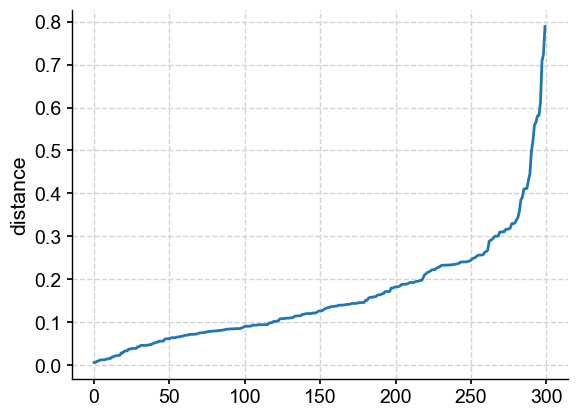

In [99]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylabel('distance')

From this plot, it would make sense to sweep from 0.05 to 0.8. If you are familiar with DBSCAN, you know that this method can be used to define the "best" `eps` value as the "knee" of the curve (or elbow depending on your perspective). This would indicate that `0.3` would have been the best value; yet we have shown that it defnitely isn't. For this reason, Pyleoclim does not emply this method by default and we caution against the use of it. 

In [100]:
eps_list = np.linspace(0.05, 0.8, 20)

Now let's sweep!... and keep track of a few things: 

In [101]:
nbr_clusters=[] # the number of clusters
sil_score =[] # the silhouette score
eps_matrix=[] # tracking the value of eps for each min_sample
min_sample_matrix=[] # tracking the value of min_sample for each eps

In [102]:
for eps in eps_list:
    for min_samples in min_samples_list:
        eps_matrix.append(eps)
        min_sample_matrix.append(min_samples)
        m = DBSCAN(eps=eps, min_samples=min_samples)
        m.fit(X)
        nbr_clusters.append(len(np.unique(m.labels_)))
        try:
            sil_score.append(silhouette_score(X, m.labels_))
        except:
            sil_score.append(np.nan)

In [103]:
import pandas as pd

In [104]:
res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score})
res

,eps,min_samples,number of clusters,silhouette score
0,0.05,2,20,-0.624168
1,0.05,3,2,-0.224822
2,0.05,4,1,NaN
3,0.05,6,1,NaN
4,0.05,7,1,NaN
...,...,...,...,...
995,0.80,69,1,NaN
996,0.80,70,1,NaN
997,0.80,72,1,NaN
998,0.80,73,1,NaN


And now let's locate the maximum value of the silhouette score (which hopefully is close to 1):

In [105]:
res.loc[res['silhouette score']==np.max(res['silhouette score'])]

,eps,min_samples,number of clusters,silhouette score
905,0.760526,9,5,0.672543
906,0.760526,10,5,0.672543
955,0.800000,9,5,0.672543
956,0.800000,10,5,0.672543


This looks promising: I'm beeing told that I have 5 clusters (the 4 clusters I asked for in the blob + the outliers) and the silhouette score is closer to 1. Let's plot #906:

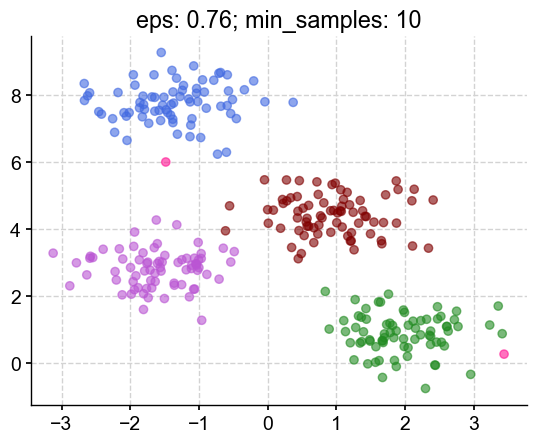

In [106]:
m3 = DBSCAN(eps=0.760526, min_samples=10)
m3.fit(X)
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'deeppink']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(X[:,0], X[:,1], c=vectorizer(m3.labels_), alpha=0.6)
plt.title('eps: 0.76; min_samples: 10')
plt.show()

The clusters look like something I would have chosen by eye, with 2 outliers (deep pink) on the outside. 

#### k-means

Pyleoclim uses the k-means method from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). In this case, the most important parameter is the number of clusters. Let's use this algorithm on the blobs, with a number set to 4:

In [107]:
from sklearn.cluster import KMeans

In [108]:
kmeans = KMeans(n_clusters=4)
m = kmeans.fit(X)

Let's have a look at our four clusters:

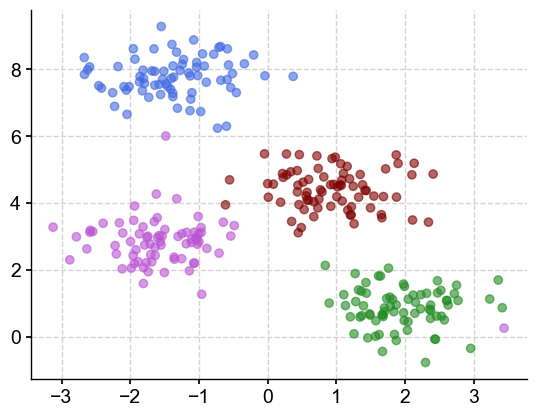

In [109]:
colors=['royalblue', 'maroon', 'forestgreen', 'mediumorchid']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X[:,0], X[:,1], c=vectorizer(m3.labels_), alpha=0.6)

Now that we have our four clusters, how do we determing the outliers? Essentially outliers can be thought of as any point sitting some distance away (as determined by a `threshold`) from the cluster centroid.

In [110]:
import math

threshold = 1
center=m.cluster_centers_[m.labels_]
distance = []
for idx,item in enumerate(center):
    distance.append(math.dist(item,X[idx,:]))
idx_out = np.argwhere(np.array(distance)>threshold).reshape(1,-1)[0]

Let's plot our clusters and outliers in red:

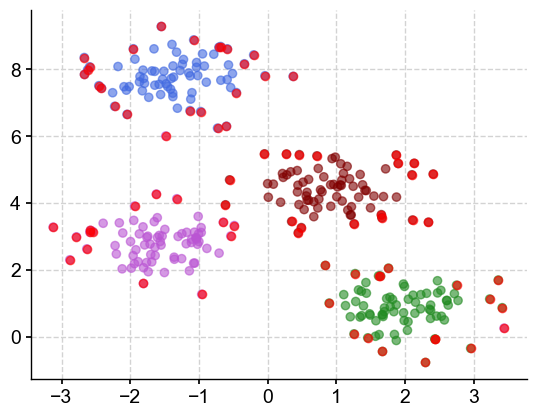

In [111]:
plt.scatter(X[:,0], X[:,1], c=vectorizer(m3.labels_), alpha=0.6)
plt.scatter(X[idx_out,0], X[idx_out,1],c='r', alpha=0.6)

How to choose the right number of clusters? Visual inspection can be useful but a simlar sweep with the sillhouette score as the performance metric can also be used.

### Outlier detection in Pyleoclim

Pyleoclim employs the two clustering algorithms details aboved for its [outlier detection](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.outliers) in timeseries data. The functions take several arguments, the most relevant being listed here:

* method – You can select either 'kmeans' or 'DBSCAN'
* remove (bool, optional) – If True, removes the outliers. 
* settings (dict, optional) – Specific arguments for the clustering functions. As detailed above the argument for each of these methods can be quite different. Let's have a look:

    * [DBSCAN](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsutils.detect_outliers_DBSCAN):
        * nbr_clusters – Number of clusters. Remember that the DSBCAN method finds the number of clusters automatically. This is an optimization parameter, allowing you to override the behavior of looking for the highest silhouette score. 
        * eps – epsilon. The default is None, which allows the algorithm to optimize for the best value of eps, using the silhouette score as the optimization criterion. The sweep is made over eps values determined from nearest neighbors optimization as described above. You can choose to pass your own list for the sweep or choose one value. 
        * min_samples – The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. The default is None and optimized using the silhouette score. The sweep occurs from 2 to len(y)/4. You can pass your own list for the sweep. 
        * n_neighbors – Number of neighbors to use by default for kneighbors queries, which can be used to calculate a range of plausible eps values. The default is None, which results in using the scikit-learn default.
    
    * [kmeans](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsutils.detect_outliers_kmeans):
        * nbr_clusters – A user number of clusters to considered. The default is None to use the optimization from the Silhouette Score. If the number of clusters can be inferred from a plot, use this parameter to set it. 
        * max_cluster – The maximum number of clusters to consider in the optimization based on the Silhouette Score. The default is 10.
        * threshold – The algorithm uses the suclidean distance for each point in the cluster to identify the outliers. This parameter sets the threshold on the euclidean distance to define an outlier. The default is 3. By default, the algorithm standardizes the timeseries. Therefore, a value of 3 represents three standard deviation away from the mean. 
        * LOF – By default, detect_outliers_kmeans uses **euclidean distance** for outlier detection (LOF = False). Set LOF to True to use [**LocalOutlierFactor**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) for outlier detection. LOF measures the local deviation of the density of a given sample with respect to its neighbors. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.
        * n_frac – The percentage of the time series length (the length, representing number of points) to be used to set the n_neighbors parameter for the LOF function in scikit-learn. We recommend using at least 50% (n_frac=0.5) of the timeseries. You cannot use 100% (n_frac!=1)
        * contamination – Same as LOF parameter from scikit-learn. We recommend using the default mode of 'auto'. See [scikit-learn document](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) for details.
    
* fig_outliers – Whether to display the timeseries showing the outliers. The default is True. This is a diagnostic plot, showing you the outliers in red. 
* fig_clusters – Whether to display the clusters. The default is True. This is a diagnostic plot. 
* keep_log – Keeps a log of the transformation. We recommend setting this value to `True` since the log will contain several diagnostics that can be very useful. 

Let's give this a try on the MD98-2181 series. As you can imagine, trends can be problematic for clustering so let's remove it. 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='SST [deg C]'>)

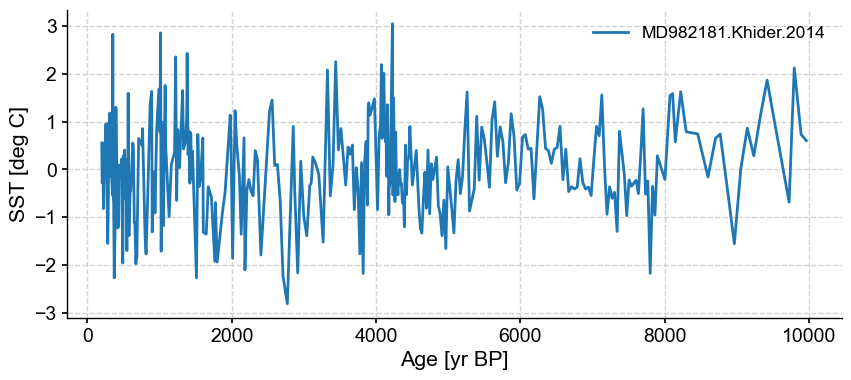

In [112]:
ts_p = ts.detrend().standardize()

ts_p.plot()

And let's apply our outlier algorithm. We will start with `kmeans`, which is the default in Pyleoclim. Remember that these algorithms are fundamentally different, and may return different clusters. 

#### Outlier dectection using k-means

For the purpose of demonstration, let's set the `remove` parameter to `False` and keep the log.

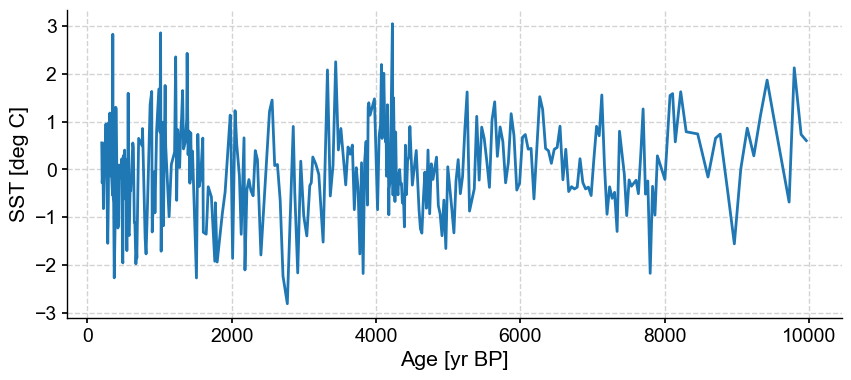

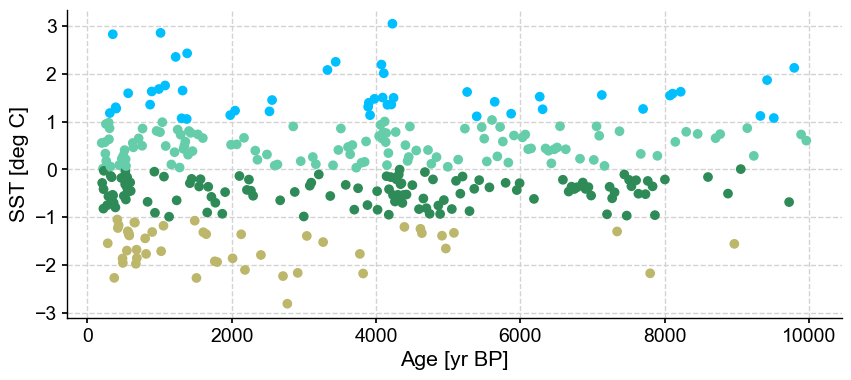

In [113]:
ts_out = ts_p.outliers(method='kmeans', remove=False, keep_log=True)

Using the default settings, the number of clusters that maximizes the silhouette score is 4, with no outliers detected. Let's have a look at the diagnostic kept in the log:

In [114]:
ts_out.log[0]['results']

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.557350,[],"[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, ..."
1,3,0.532020,[],"[1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 1, ..."
2,4,0.565988,[],"[2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 0, 3, 2, 2, ..."
3,5,0.541227,[],"[0, 1, 0, 1, 1, 0, 0, 0, 4, 0, 1, 3, 1, 4, 4, ..."
4,6,0.543066,[],"[3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 2, 4, 0, 1, 3, ..."
5,7,0.561999,[],"[6, 5, 1, 2, 5, 1, 6, 1, 6, 1, 2, 3, 5, 6, 6, ..."
6,8,0.554498,[],"[5, 6, 0, 3, 6, 0, 5, 0, 5, 0, 3, 7, 6, 5, 5, ..."
7,9,0.540954,[],"[8, 0, 5, 7, 0, 5, 8, 8, 1, 5, 7, 4, 7, 1, 8, ..."
8,10,0.543240,[],"[6, 3, 9, 0, 5, 3, 6, 9, 1, 9, 0, 7, 5, 1, 6, ..."


The dataframe contains several pieces of information:
* the number of clusters - Remember that this is set as in input to the k-means algorithm and we are sweeping over this range of values.
* the silhouette score - Notice that it doesn't vary much in this case for the various number of clusters. 
* the indices of the outliers - In this case, there are none. 
* the cluster assignment for each point - This can be valuable if you are more interested in recovering the clusters than the outliers.

But let's consider the silhouette score for a minute. There is not much difference between 0.557 (2 clusters) and the optimized 0.565 (4 clusters). However, an argument could be made that there are really two clusters in this series (above and below 0) and the outlying clusters in turquoise and light blue are just representing the noise.

Let's run this again, but impose 2 clusters:

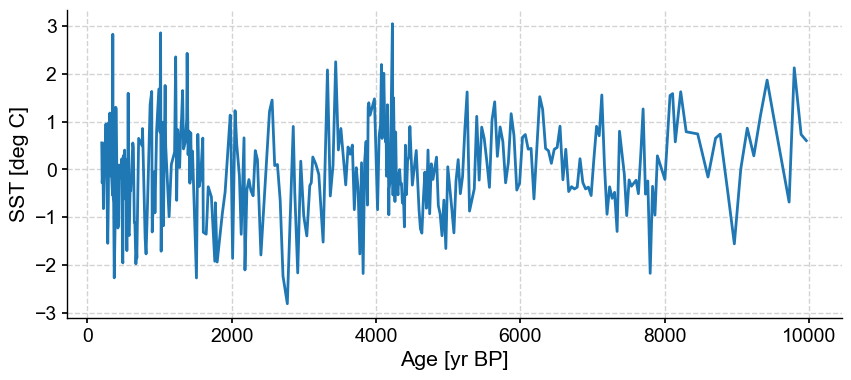

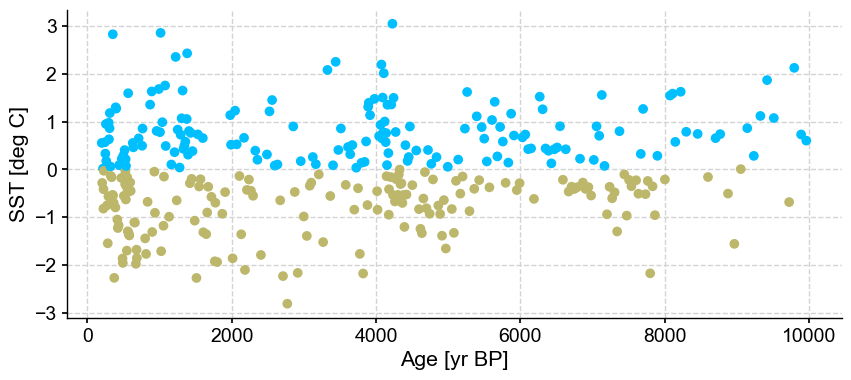

In [115]:
ts_out = ts_p.outliers(method='kmeans', settings={'nbr_clusters':2}, remove=False, keep_log=True)

Results are very much identical, with no outliers being detected. 

Let's lower the threshold:

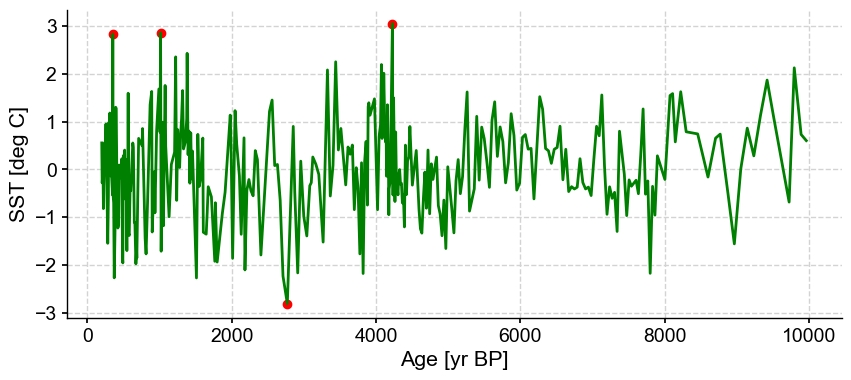

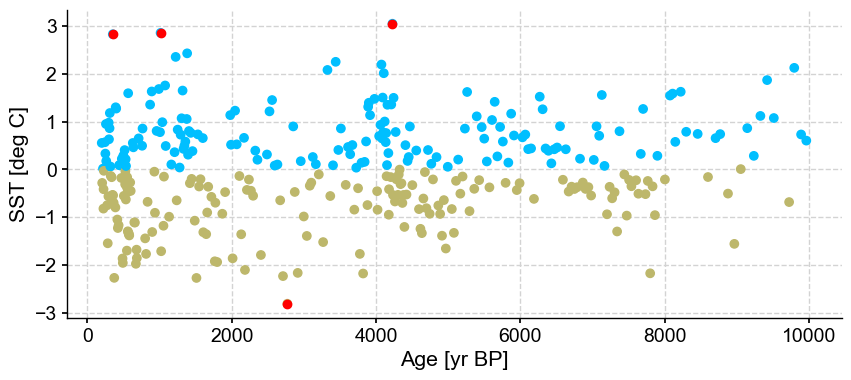

In [116]:
ts_out = ts_p.outliers(method='kmeans', settings={'nbr_clusters':2, 'threshold':2}, remove=False, keep_log=True)

With a lower threshold, the outmost values are being removed, which is not surprising. This is the most sensitive parameter when using the k-mean algorithm and should be chosen with care. 

Next, let's try out the other outlier detection methods: LOF. We start with the default settings of n_frac = 0.9 and contamination = 'auto'.

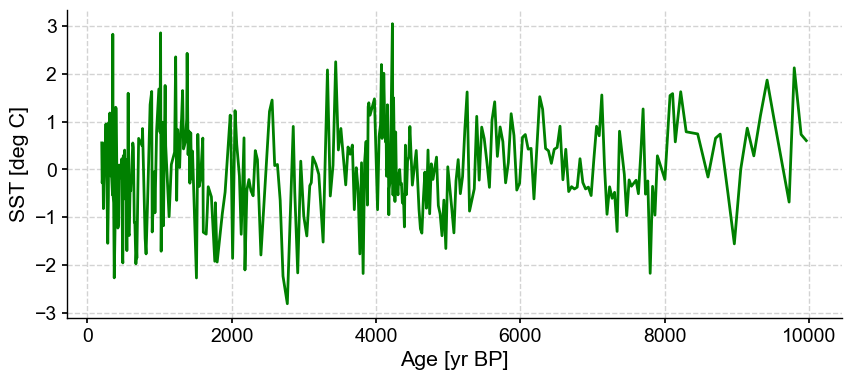

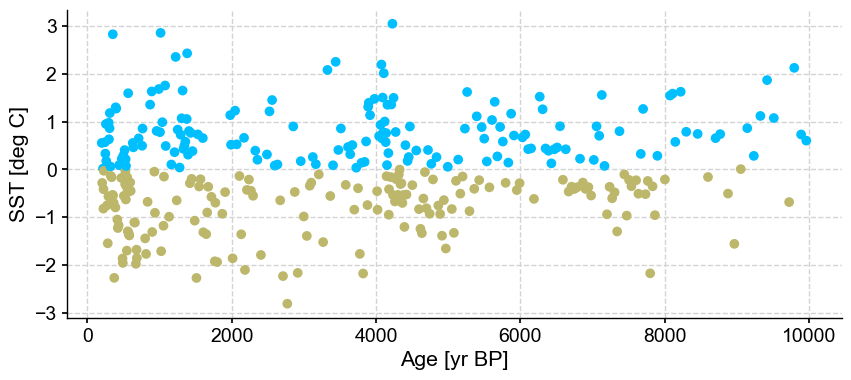

In [127]:
ts_out = ts_p.outliers(method='kmeans', settings={'nbr_clusters':2, 'LOF':True}, remove=False, keep_log=True)

Results are identical with previous one using euclidean distance with no outliers being detected.

Let's tweak the two parameters associated with LOF and observe the result.

By setting n_frac, we tell the function the proportion of nearest sample points we take in to consider a sample point as an outlier. As for contamination, giving it a value means how much proportion of outliers we think may be in the dataset.

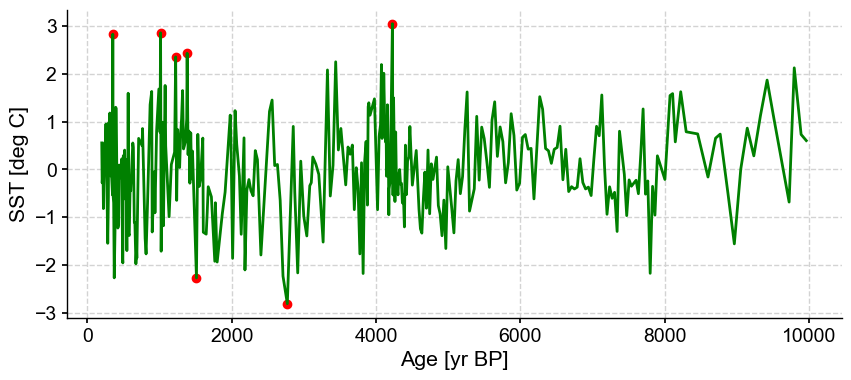

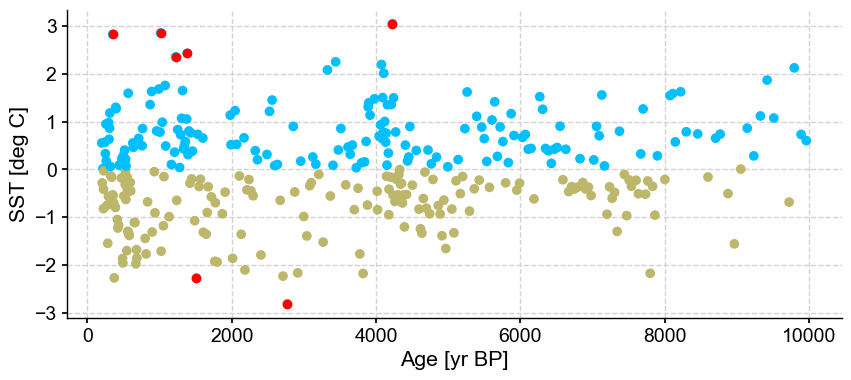

In [128]:
ts_out = ts_p.outliers(method='kmeans', settings={'nbr_clusters':2, 'LOF':True, 'n_frac':0.8, 'contamination':0.02}, remove=False, keep_log=True)

With the tweaked two parameters, several outmost values are being removed.

#### Outlier detection with DBSCAN

Let's turn our attention to DBSCAN:

Optimizing for the best number of clusters, this may take a few minutes


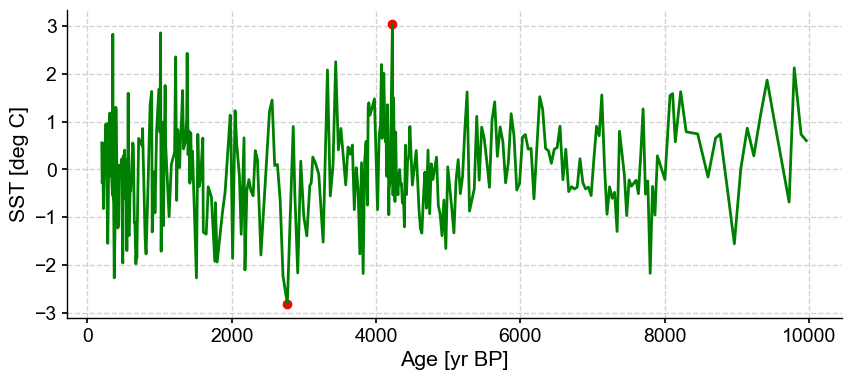

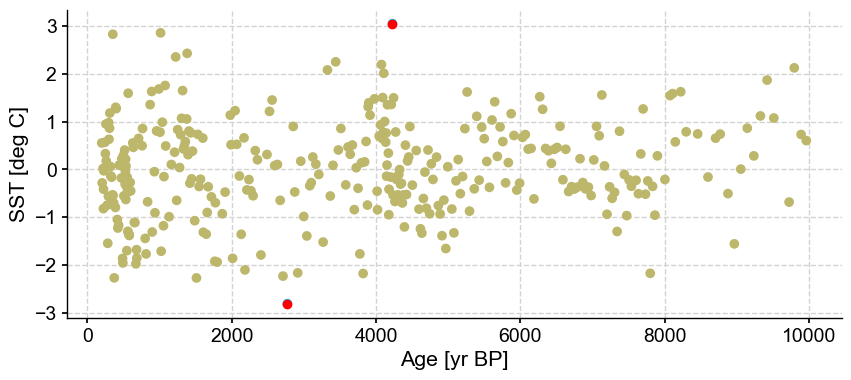

In [129]:
ts_out = ts_p.outliers(method='DBSCAN', remove=False, keep_log=True)

The algorithm optimizes for one cluster and two outliers. Let's have a look at the log, which will contain the silhouette score:

In [130]:
res = ts_out.log[0]['results']
res

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
0,0.010000,2,65,0.346318,"[2, 8, 11, 13, 14, 16, 21, 25, 26, 28, 29, 30,...","[0, 1, -1, 2, 3, 4, 5, 6, -1, 7, 8, -1, 9, -1,..."
1,0.010000,3,44,0.185807,"[0, 2, 8, 11, 13, 14, 16, 17, 21, 24, 25, 26, ...","[-1, 0, -1, 1, 2, 15, 3, 32, -1, 4, 5, -1, 6, ..."
2,0.010000,5,15,-0.272447,"[0, 2, 3, 5, 7, 8, 9, 10, 11, 13, 14, 16, 17, ...","[-1, 0, -1, -1, 1, -1, 13, -1, -1, -1, -1, -1,..."
3,0.010000,7,3,-0.280342,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
4,0.010000,8,2,-0.306025,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
...,...,...,...,...,...,...
2495,5.665417,77,0,NaN,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2496,5.665417,79,0,NaN,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2497,5.665417,80,0,NaN,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2498,5.665417,82,0,NaN,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


The log contains the values of `eps` and `min_samples` that were tried, the number of resulting clusters, the silhouette score, the indices of the outliers and the cluster assignment. 

Let's look for the maximum value of the silhouette score:

In [131]:
res.loc[res['silhouette score']==np.max(res['silhouette score'])]

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
202,0.471667,5,1,0.616233,"[145, 201]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
203,0.471667,7,1,0.616233,"[145, 201]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
204,0.471667,8,1,0.616233,"[145, 201]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Several combinations result in a similar silhouette score (by default, Pyleoclim will work with the first one), with a `eps` value of 0.47. Let's make sure that this value is not the maximum that was tried (if so, I would recommend passing your own list of eps value direclty):

In [132]:
res['eps'].max()

5.6654168267442895

In [133]:
res['eps'].min()

0.01

This seems reasonable (and not an artifact of the limits on the parameter sweeps). Note that DBSCAN and k-means both identified a common set of outliers that could be candidates for removal. Generally, if the answers are sensitive to the method and parameters, then it is a good indication that the method is too sensitive and conclusions (i.e., whether the data points are outliers) are not robust. If this is the case, proceed carefully with `remove`. 